In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, cut_tree

## Clustering

In [2]:
# Read in fpkm values
fpkm = pd.read_csv('fpkm_vals')

Limit the dataset to genes with a median expression across samples to greater than zero.

In [3]:
# Limit dataset to genes with a median expression across samples > 0
fpkm = fpkm[fpkm.median(axis=1)>0]

Apply a log2(FPKM+0.1) transformation to the data.

In [4]:
# Subset fpkms from dataset
df1 = fpkm.iloc[:,2:]

In [5]:
# Add 0.1 to all fpkms
df2 = df1.add(0.1)
# Take log2 of all values
df2 = np.log2(df2)

In [58]:
# Merge transformed values with gene names
fpkm_log = pd.merge(fpkm.iloc[:,0:2], df2, left_index=True, right_index=True)
#fpkm_log

Cluster data matrix for both genes and samples on their patterns of expression.

In [57]:
# Cluster based on genes 
Z1 = linkage(fpkm_log.iloc[:,2:], method='average', metric='euclidean')
#Z1

In [8]:
# Transpose data for sample clustering 
fpkm_trans = fpkm_log.T

In [9]:
# Cluster based on samples 
Z2 = linkage(fpkm_trans.iloc[2:,:])
leaves_list(Z2)

array([ 6, 14,  7, 15,  5, 13,  1,  4, 12, 11,  9,  3,  8,  0,  2, 10],
      dtype=int32)

Create dendrogram relating samples to one another

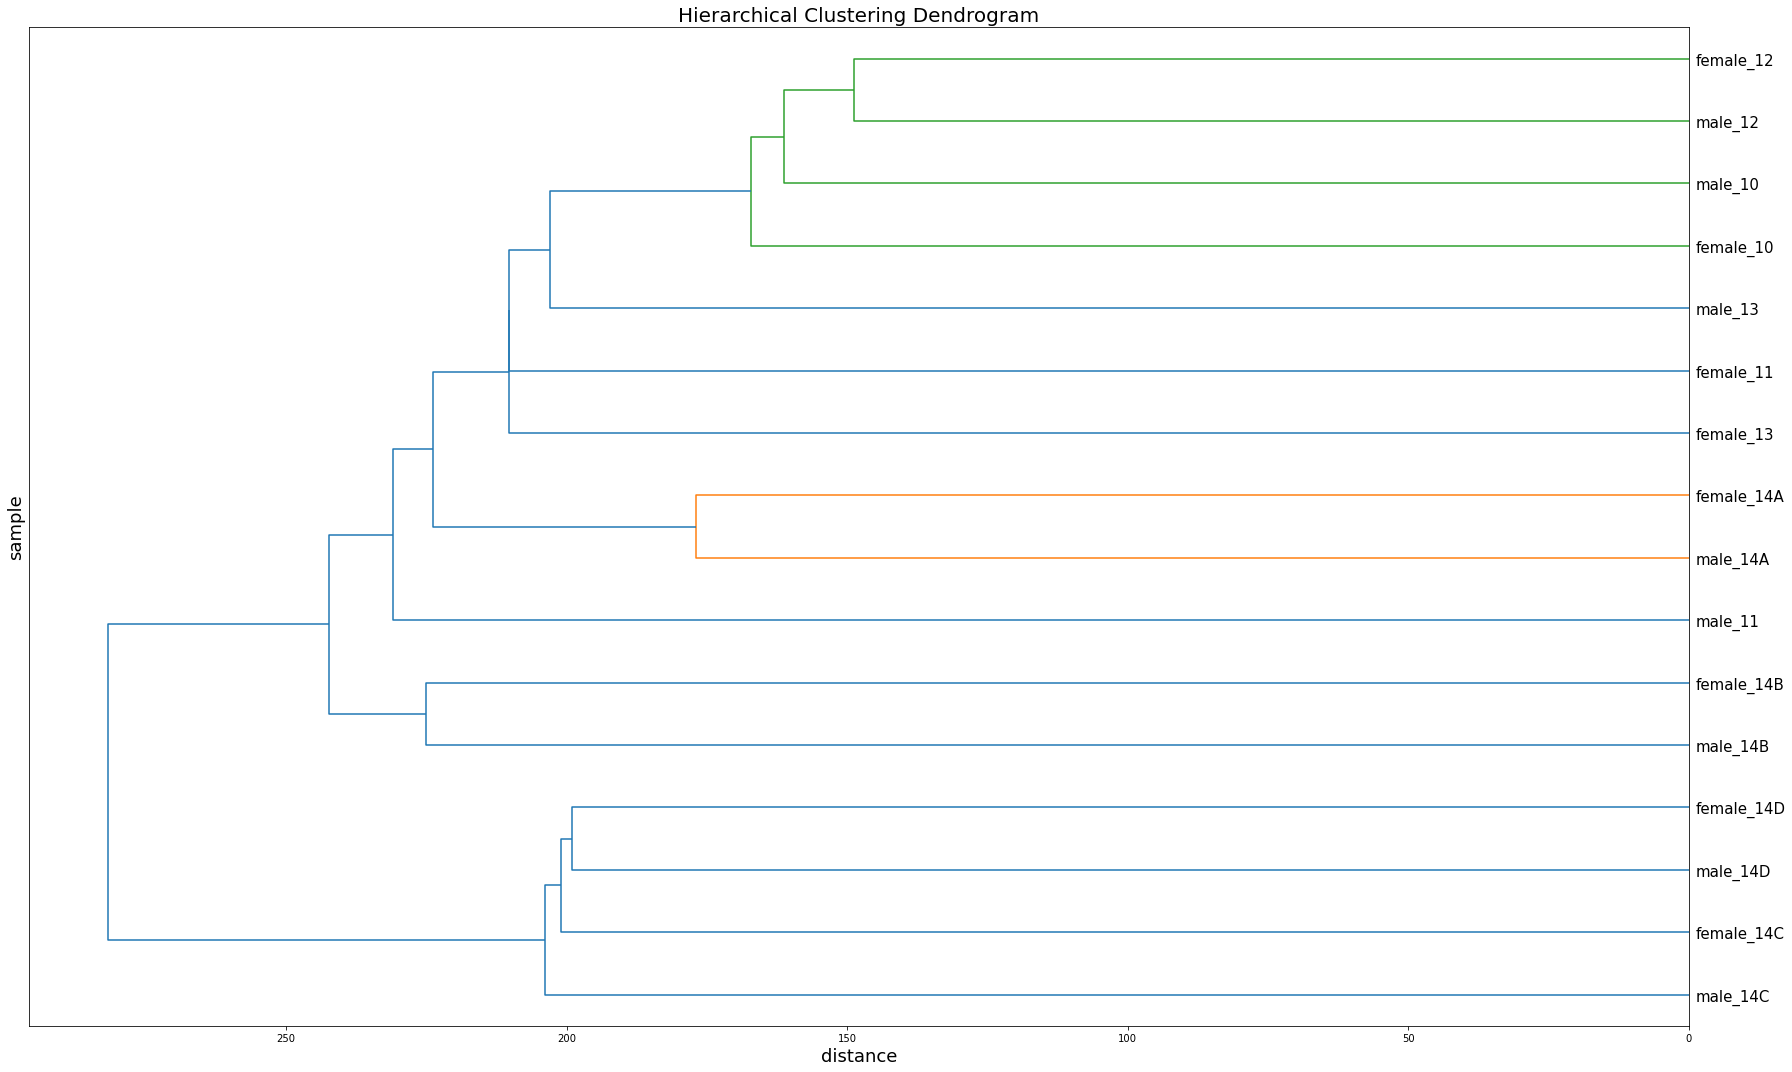

In [10]:
fig, ax = plt.subplots(figsize=(25,15))
ax.set_title('Hierarchical Clustering Dendrogram',fontsize=20)
ax.set_xlabel('distance', fontsize=18)
ax.set_ylabel('sample', fontsize=18)
dendrogram(Z2, leaf_rotation=0, leaf_font_size=15,
          show_contracted=True,
          labels=fpkm_trans.index[2:],
          orientation='left')
plt.tight_layout()
fig.savefig('samples_dendrogram.png')
plt.show()

### Heatmap

Plot a heatmap of the gene expression data.

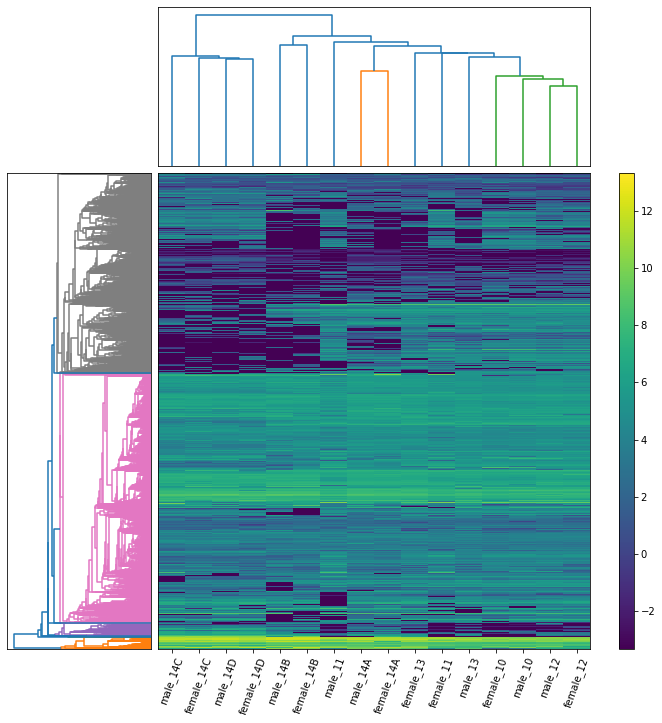

In [11]:
# 2D array that contains data 
D = np.array(fpkm_log.iloc[:,2:])

# Create list for x axis labels based on dendrogram clustering
labels = ['male_14C','female_14C','male_14D','female_14D', 'male_14B',
         'female_14B','male_11','male_14A','female_14A','female_13',
         'female_11','male_13','female_10','male_10','male_12',
         'female_12']

fig = plt.figure(figsize=(10,11))

# Left dendrogram for genes
# Add axes at bottom position
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y1 = linkage(fpkm_log.iloc[:,2:], method='average', metric='euclidean')
Z1 = dendrogram(Y1, orientation='left')
# Hide ticks
ax1.set_xticks([])
ax1.set_yticks([])

# Top dendrogram for samples
ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
Y2 = linkage(fpkm_trans.iloc[2:, :])
Z2 = dendrogram(Y2)
ax2.set_xticks([]) # Hide ticks
ax2.set_yticks([]) # Hide ticks

# Plot distance matrix 
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves'] # Apply clustering for gene dendrograms to matrix data
idx2 = Z2['leaves'] # Apply clustering for sample dendrograms to matrix data
D = D[idx1, :] # Reorder flat cluster to match order of leaves of dendrogram
D = D[:, idx2] # Reorder flat cluster to match order of leaves of dendrogram
im = axmatrix.matshow(D, aspect='auto',origin='lower',cmap='viridis')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# xticks for x-axis
axmatrix.set_xticks(np.arange(len(labels)))
axmatrix.set_xticklabels(labels, rotation=70)
axmatrix.xaxis.set_label_position('bottom')
axmatrix.xaxis.tick_bottom()

# add color bar
axcolor = fig.add_axes([0.94, 0.1, 0.02, 0.6], frame_on=False)
plt.colorbar(im, cax=axcolor)

plt.show()
fig.savefig('heatmap.png')

## Differential expression

Use ordinary least squares regression to test for genes that are differentially expressed across stages. 
Use the stage number as a numeric independent variable (10, 11, 12, 13, 14) and ignore the letter suffixes on day 14 (treat 14A, B, C, and D as equivalent).

In [12]:
fpkm_trans['Stage'] = ['NA','NA',10,11,12,13,14,14,14,14,10,11,12,13,14,14,14,14]
fpkm_trans['Sex'] = ['NA','NA','male','male','male','male','male',
                    'male','male','male','female','female','female',
                    'female','female','female','female','female']
# Assign gene names to headers object
headers = fpkm_trans.iloc[0]
# Create new dataframe with gene names as column headers
fpkm_new = pd.DataFrame(fpkm_trans.values[2:],columns=headers)
# Add column for sex
fpkm_new.columns = [*fpkm_new.columns[:-1],'Sex']
# Add column for stage
fpkm_new = fpkm_new.rename(columns={fpkm_new.columns[-2]: 'Stage'})

In [13]:
# Subset fpkms from dataframe
fpkm_vals = fpkm_new.iloc[:,:-1]
fpkm_cat = fpkm_new.iloc[:, -1:]
# Convert to numeric
fpkm_vals = fpkm_vals.apply(pd.to_numeric)

In [14]:
fpkm_vals.dtypes

FBtr0302347    float64
FBtr0113885    float64
FBtr0301810    float64
FBtr0113895    float64
FBtr0345179    float64
                ...   
FBtr0100886    float64
FBtr0100888    float64
FBtr0114261    float64
FBtr0114216    float64
Stage            int64
Length: 8614, dtype: object

In [15]:
# Merge dataframes
fpkm_new = pd.concat([fpkm_vals.reset_index(drop=True), fpkm_cat.reset_index(drop=True)], axis=1)

In [16]:
list_of_responses = list(fpkm_new.columns[0:-2])
# list of models 
models = []
for resp in list_of_responses:
    formula = resp + "~ 1 + Stage"
    model = smf.ols(formula = formula, data = fpkm_new)
    results = model.fit()
    models.append(results)

In [17]:
# View results also view p values
models[0].summary()

/Users/cmdb/miniconda3/envs/cmdb/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            FBtr0302347   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.1184
Date:                Thu, 05 Nov 2020   Prob (F-statistic):              0.736
Time:                        14:15:13   Log-Likelihood:                -9.0357
No. Observations:                  16   AIC:                             22.07
Df Residuals:                      14   BIC:                             23.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8414      0.987      3.891      0.002       1.724       5.959
Stage          0.0265      0.077      0.344      0.736      -0.138       0.191
==============================================================================
Omnibus:                        2.115   Durbin-Watson:                   2.604
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.005
Skew:                           0.102   Prob(JB):                        0.605
Kurtosis:                       1.789   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# Check that it performed test for all genes
len(models)

8613

Generate a QQ plot from the p-values.

In [56]:
# Get pvals from results
pvals = []
for val in models:
    # Use pval for stage
    pvals.append(val.pvalues[1])

# Create dataframe from pvals 
df_pvals = pd.DataFrame(pvals,columns=['P'])
#df_pvals

In [55]:
# Merge with original gene name 
df_merge = pd.concat([fpkm_log['t_name'].reset_index(drop=True), fpkm_log['gene_name'].reset_index(drop=True), df_pvals.reset_index(drop=True)], axis=1)
#df_merge

In [54]:
df_sorted = df_merge.sort_values(by="P")
df_sorted['uniform_points'] = range(0, len(df_sorted))
df_sorted['uniform_pval'] = (df_sorted['uniform_points'] + 1)/len(df_sorted)
df_sorted['uniform_logP'] = -1 * np.log10(df_sorted['uniform_pval'])
df_sorted['logP'] = -1*np.log10(df_sorted['P'])
#df_sorted

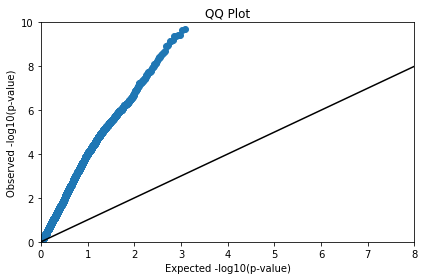

In [22]:
fig, ax = plt.subplots()
ax.scatter(df_sorted["uniform_logP"], df_sorted["logP"])
ax.plot([8,0],[8,0], color="black")
ax.set_ylim([0,10])
ax.set_xlim([0,8])
ax.set_xlabel("Expected -log10(p-value)")
ax.set_ylabel("Observed -log10(p-value)")
ax.set_title("QQ Plot")
plt.tight_layout()
fig.savefig('qq_plot.png')
plt.show()

Report the list of genes that exhibit differential expression by stage at a 10% false discovery rate.

In [53]:
# FDR correction for 10%
from statsmodels.stats import multitest
df_sorted["sig_fdr_bf_0.1"] = multitest.multipletests(df_sorted["P"],
                                                      method = "fdr_bh",
                                                      alpha = 0.1)[0]
#df_sorted

In [24]:
# tabulate significant results 
df_sorted["sig_fdr_bf_0.1"].value_counts()

False    4823
True     3790
Name: sig_fdr_bf_0.1, dtype: int64

There are 3790 genes that exhibit differential expression by stage at a 10% FDR.

In [46]:
# Extract those that satisfy condition
diff_genes = df_sorted[df_sorted['sig_fdr_bf_0.1'] == True]
# Get gene names column
diff_genes_list = diff_genes[['t_name']]
# Write to txt file 
diff_genes_list.to_csv('diff_genes.txt',header=True,index=False,sep='\n',mode='a')

Repeat the analysis while controlling for sex.

In [26]:
list_of_responses2 = list(fpkm_new.columns[0:-2])
# list of models 
models2 = []
for resp in list_of_responses:
    # Add sex as a covariate
    formula = resp + "~ Stage + Sex"
    model = smf.ols(formula = formula, data = fpkm_new)
    results = model.fit()
    models2.append(results)

In [27]:
models2[0].summary()

/Users/cmdb/miniconda3/envs/cmdb/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            FBtr0302347   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.144
Method:                 Least Squares   F-statistic:                   0.05591
Date:                Thu, 05 Nov 2020   Prob (F-statistic):              0.946
Time:                        14:16:00   Log-Likelihood:                -9.0346
No. Observations:                  16   AIC:                             24.07
Df Residuals:                      13   BIC:                             26.39
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.8465      1.031      3.730      0.003       1.619       6.074
Sex[T.male]    -0.0102      0.236     -0.043      0.966      -0.520       0.500
Stage           0.0265      0.080      0.332      0.745      -0.146       0.199
==============================================================================
Omnibus:                        2.279   Durbin-Watson:                   2.597
Prob(Omnibus):                  0.320   Jarque-Bera (JB):                1.039
Skew:                           0.105   Prob(JB):                        0.595
Kurtosis:                       1.770   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
models2[0].pvalues

Intercept      0.002520
Sex[T.male]    0.966161
Stage          0.745479
dtype: float64

In [29]:
# Get pvals from results
pvals2 = []
for val2 in models2:
    # Use pval for stage again
    pvals2.append(val2.pvalues[2])

# Create dataframe from pvals 
df_pvals2 = pd.DataFrame(pvals2,columns=['P'])

In [51]:
# Merge with original t_name 
df_merge2 = pd.concat([fpkm_log['t_name'].reset_index(drop=True), fpkm_log['gene_name'].reset_index(drop=True), df_pvals2.reset_index(drop=True)], axis=1)
#df_merge2

In [52]:
df_sorted2 = df_merge2.sort_values(by="P")
df_sorted2['uniform_points'] = range(0, len(df_sorted2))
df_sorted2['uniform_pval'] = (df_sorted2['uniform_points'] + 1)/len(df_sorted2)
df_sorted2['uniform_logP'] = -1 * np.log10(df_sorted2['uniform_pval'])
df_sorted2['logP'] = -1*np.log10(df_sorted2['P'])
#df_sorted2

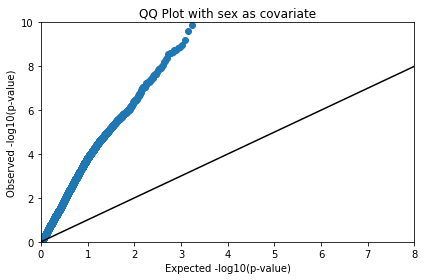

In [32]:
fig, ax = plt.subplots()
ax.scatter(df_sorted2["uniform_logP"], df_sorted2["logP"])
ax.plot([8,0],[8,0], color="black")
ax.set_ylim([0,10])
ax.set_xlim([0,8])
ax.set_xlabel("Expected -log10(p-value)")
ax.set_ylabel("Observed -log10(p-value)")
ax.set_title("QQ Plot with sex as covariate")
plt.tight_layout()
fig.savefig('qq_plot_cov.png')
plt.show()

Report the list of genes that exhibit differential expression by stage at a 10% false discovery rate while controlling for sex.

In [33]:
# FDR correction for 10%
from statsmodels.stats import multitest
df_sorted2["sig_fdr_bf_0.1"] = multitest.multipletests(df_sorted2["P"],
                                                      method = "fdr_bh",
                                                      alpha = 0.1)[0]
df_sorted2

,t_name,gene_name,P,uniform_points,uniform_pval,uniform_logP,logP,sig_fdr_bf_0.1
5153,FBtr0071924,Ppa,6.477941e-14,0,0.000116,3.935154,13.188563,True
5154,FBtr0330249,Ppa,6.477941e-14,1,0.000232,3.634124,13.188563,True
5152,FBtr0343014,Ppa,1.140239e-13,2,0.000348,3.458033,12.943004,True
7951,FBtr0080193,CG14915,2.904440e-11,3,0.000464,3.333094,10.536938,True
2209,FBtr0072872,CG8960,1.323227e-10,4,0.000581,3.236184,9.878366,True
...,...,...,...,...,...,...,...,...
5958,FBtr0071095,RpS14a,9.984889e-01,8608,0.999536,0.000202,0.000657,False
5601,FBtr0345315,CG2924,9.988044e-01,8609,0.999652,0.000151,0.000520,False
1060,FBtr0300247,CG7215,9.991187e-01,8610,0.999768,0.000101,0.000383,False
2518,FBtr0076886,RhoGEF4,9.995516e-01,8611,0.999884,0.000050,0.000195,False


In [34]:
# tabulate significant results 
df_sorted2["sig_fdr_bf_0.1"].value_counts()

False    4946
True     3667
Name: sig_fdr_bf_0.1, dtype: int64

There are 3667 genes differentially expressed between stages when using sex as covariate.

In [45]:
# Extract those that satisfy condition
diff_genes2 = df_sorted2[df_sorted2['sig_fdr_bf_0.1'] == True]
# Get gene names column
diff_genes_list2 = diff_genes2[['t_name']]
# Write to txt file 
diff_genes_list2.to_csv('diff_genes_cov.txt',header=True,index=False,sep='\n',mode='a')

In [42]:
len(diff_genes_list)

3790

In [43]:
len(diff_genes_list2)

3667

Compare the lists - what is the percentage overlap with and without sex as a covariate?
((# overlapping genes)/(# genes in list without covariate))*100

In [50]:
df_overlap = pd.merge(diff_genes_list, diff_genes_list2, how='inner', on=['t_name'])
#df_overlap

## Percent overlap

In [37]:
# Calculate percentage overlap 
overlap = (len(df_overlap)/len(diff_genes_list))*100
overlap

96.25329815303431

In [47]:
overlap2 = (len(df_overlap)/len(diff_genes_list2))*100
overlap2

99.48186528497409

Generate a volcano plot of the differential expression, with sex as a covariate, results (-log10(p-value) on the y-axis, beta on the x-axis). Color the significant points in a different color.

In [38]:
models2[1].params

Intercept     -10.113700
Sex[T.male]    -0.903806
Stage           0.880440
dtype: float64

In [48]:
# Get beta values for x-axis (coef)
# Get pvals from results
beta = []
for param in models2:
    # Beta for stage
    beta.append(param.params[2])

# Create dataframe from pvals 
df_beta = pd.DataFrame(beta,columns=['beta'])

In [49]:
df_vol = pd.concat([df_beta.reset_index(drop=True), df_merge2.reset_index(drop=True)], axis=1)
df_vol['logP'] = -1*np.log10(df_vol['P'])
#df_vol

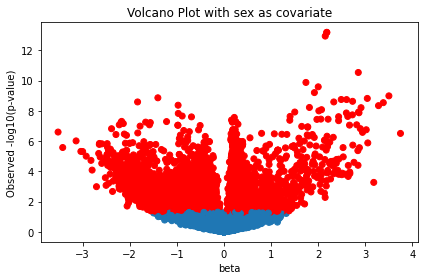

In [41]:
fig, ax = plt.subplots()
x = df_vol["beta"]
y = df_vol["logP"]
colors = ['red' if val > -1*np.log10(0.05) else 'C0' for val in y]

ax.scatter(x, y, color=colors)
ax.set_xlabel("beta")
ax.set_ylabel("Observed -log10(p-value)")
ax.set_title("Volcano Plot with sex as covariate")
plt.tight_layout()
fig.savefig('volcano_plot.png')
plt.show()